<a href="https://colab.research.google.com/github/BrianKEverett/County-Line/blob/main/Final_Everett_Cleaner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Research Questions, Hypotheses, Abstract
This notebook will work toward examining planning board behavior in the state of New Jersey as an extended function of the County Line balloting system. There is a growing body of literature regarding New Jersey's unique way of designing primary ballots in team-based formats. Some scholars suggest this approach to ballot design favors powerful insiders, and mirrors what we might find in Soviet Russia. Such ballot design in New Jersey gives those who receive placement on the party's line up to a 38% electoral advantage.

Not every New Jersey county following the County Line balloting system, though. Salem and Sussex counties do not design their primary ballots in this manner, while the other 19 counties do. Furthermore, planning boards are made up of members who are appointed by a municipalities mayor, so it is possible to envision an extension of the "insiderism" that comes through the County Line system to effect the decisions made by planning boards. The notebook below seeks to begin answering the following questions:

1) Are the less high-dollar permits approved in non-County Line counties?

2) Do high-dollar permits corelate with jobs in a given municipality?

3) Do property taxes change with more or less high-dollar permits being approved?

## Pandas Setup

In [31]:
!pip install ydata-profiling
from ydata_profiling import ProfileReport

In [32]:
import time, os, sys, re
import zipfile, json, datetime, string
import numpy as np
from statistics import *

import matplotlib.pyplot as plt

import pandas as pd
import pandas_datareader as pdr
from pandas_datareader import wb
from pandas.io.formats.style import Styler
import plotly.express as px

import missingno as msno

from google.colab import files

import seaborn as sns

from google.colab import data_table
data_table.enable_dataframe_formatter()
data_table.max_columns = 50

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

plt.style.use('classic')

##Reading in Datasets with descriptions

In [33]:
permits=pd.read_csv("https://raw.githubusercontent.com/BrianKEverett/County-Line/main/Permits.csv")
# dataset can be found here: https://njdca.maps.arcgis.com/home/item.html?id=c754e8f800424bcbb6ad4e6e85b9f736 from NJ Dept of Community Affairs Website.
#this dataset was chosen mostly to assist with my dissertation proposal - I am seeking to explore the behaviors of planning boards in New Jersey, and one hypothesis I have is that planning board decisions are influenced by the effects of the County Line Balloting system, which is unique to 19 out of 21 counties in New Jersey. No other state in the US runs primary elections in this way.
#More on the County Line can be found here by Julia Sass Rubin: https://www.njpp.org/wp-content/uploads/2021/01/NJPP-Report-Does-the-County-Line-Matter-Update-wiht-Final-Vote-Counts.pdf

taxes=pd.read_csv ("https://raw.githubusercontent.com/BrianKEverett/County-Line/main/mediantax.csv")
# dataset can be retireved via: https://njdca.maps.arcgis.com/apps/webappviewer/index.html?id=96ec274c50a34890b23263f101e4ad9b from NJ Department of Community Affairs
# Another hypothesis I have is that the public narrative put forth by planning board members when approving controversial permits, "this will increase rateables for the township, lowering your taxes", does not actually come to fruition
#This data set is helpful for exploring that narrative, and seeing if the opposite is occurring, i.e. more development actually yields higher property taxes

#health=pd.read_csv ("https://raw.githubusercontent.com/BrianKEverett/County-Line/main/countyhealth.csv")
#dataset can be found here: https://www.countyhealthrankings.org/explore-health-rankings/rankings-data-documentation from County Health Rankings and Roadmaps, for 2022 to match same year of data for permits dataset
#With County Health Data, we can infer hypotheses about rates of development and the effect on well-being, liveability.

#Problem with health data set == only 22 observations for New Jersey, not a good sample.

municodes=pd.read_csv ("https://raw.githubusercontent.com/BrianKEverett/County-Line/main/Municodes.csv")
#Data file of all NJ municiaplities, and counties, with the corresponding municipalitiy DCA code. This data file will be most helpful for matching and merging.

#crime=pd.read_csv ("https://raw.githubusercontent.com/BrianKEverett/County-Line/main/CamdenCrime.csv") #not a good format for reading data!
#Dataset can be retireved here: https://www.nj.gov/njsp/ucr/uniform-crime-reports.shtml on the NJ Office of the Attorney General's website
#This crime data is important to consider when analyzing planning and zoning. Does any specific type of development correlate with increased crime? Can liveability theory be worked in here for whether or not communities have what they need to prevent crime?

jobs=pd.read_csv('https://raw.githubusercontent.com/BrianKEverett/County-Line/main/jobsdensity.csv')
#dataset can be built via the table selections on the NJ Community Affairs website - https://njdca.maps.arcgis.com/apps/webappviewer/index.html?id=96ec274c50a34890b23263f101e4ad9b
#Job density is a good variable to consider regarding new large dollar permits. Are some places growing more than others? Can this be attribute to the phenomenon of the County Line?

##Clean and Edit Data

In [34]:
permits = permits.rename(columns={'DCA MUNI CODE': 'DCA'})
permits = permits.rename(columns={'MUNICIPALITY': 'Municipality'})
permits["Municipality"]= permits["Municipality"].str.title()
del permits['ID']
del permits['BLOCK NUMBER']
del permits['PAMS PIN']
del permits['USE GROUP']
del permits['YCOORD']
del permits['XCOORD']
del permits['MATCH TYPE']
del permits['LOT NUMBER']
del permits['DATE ISSUED']
del permits['TAX CODE']
del permits['Use Group Label']
del permits['TYPE']

permits = permits.rename(columns={'DCA MUNI CODE': 'DCA'})
permits = permits.rename(columns={'MUNICIPALITY': 'Municipality'})
permits = permits.rename(columns={'WORK VALUE': 'value'})
permits = permits.set_index('Municipality')
permits["value"] = permits["value"].str.replace(",","").astype(float)
permits["value"].astype(np.int64)
permits.drop_duplicates()

del municodes['MUNICIPALITY_NAME_NJ-1040']
del municodes['MUNICIPALITY_CODE_DCA']
del municodes['MUNICIPALITY_NAME_DCA']
del municodes['MUNICIPALITY_CODE_GNIS']
del municodes['MUNICIPALITY_NAME_GNIS']
del municodes['MUNICIPALITY_CODE_FIPS']
municodes = municodes.rename(columns={'MUNICIPALITY_NAME_COMMON': 'Municipality'})
municodes = municodes.rename(columns={'MUNICIPALITY_CODE_NJ-1040': 'DCA'})
municodes = municodes.rename(columns={'COUNTY_NAME_COMMON': 'County'})
municodes['County'] = municodes['County'].str.replace(' County', '')
municodes = municodes.set_index('Municipality')

del jobs['Blk_Grp_Name']
del jobs['JobsVintage']
del jobs['Jobs']
jobs = jobs.set_index('Municipality')

del taxes['Data_Vintage']
del taxes['Tract_Name']
taxes = taxes.rename(columns={'Median_RE_Taxes': 'MedianTax'})
taxes = taxes[['County', 'Municipality', 'MedianTax']]
taxes = taxes.set_index('Municipality')
taxes.drop_duplicates()

Municipality
Absecon City        695000
Absecon City       4000000
Atlantic City      2100000
Atlantic City      2100000
Atlantic City       337400
                    ...   
Washington Boro    1000000
Washington Twp      426124
Washington Twp      742000
Washington Twp      276000
Washington Twp      515000
Name: value, Length: 9783, dtype: int64

DCA      value
Municipality                    
Absecon City      101   695000.0
Absecon City      101  4000000.0
Atlantic City     102  2100000.0
Atlantic City     102   337400.0
Atlantic City     102  2217000.0
...               ...        ...
Washington Boro  2121  1000000.0
Washington Twp   2122   426124.0
Washington Twp   2122   742000.0
Washington Twp   2122   276000.0
Washington Twp   2122   515000.0

[8827 rows x 2 columns]

County  MedianTax
Municipality                                          
Bridgewater Township               Somerset    10000.0
Franklin Township                  Somerset     9604.0
Woodbridge Township               Middlesex     9041.0
Woodbridge Township               Middlesex     7496.0
Woodbridge Township               Middlesex     8759.0
...                                     ...        ...
Edison Township                   Middlesex     7328.0
Woodbridge Township               Middlesex     9328.0
Lebanon Township                  Hunterdon     8554.0
Lebanon Township/Califon Borough  Hunterdon     9439.0
Franklin Township                  Somerset     6600.0

[987 rows x 2 columns]

##First Data Merge
This is important in terms of process because this merge will allow for the 'permits' dataset to be merged with other datasets later on. The 'permits' dataset lacks a County variable, and since my initial focus is on NJ Counties, I need to make sure the data in the 'permits' dataset is capable of merging later.

In [35]:
codespermits = municodes.merge(permits, how='inner', on=['DCA'])
codespermits.drop_duplicates()

County   DCA      value
0     Atlantic   101   695000.0
1     Atlantic   101  4000000.0
2     Atlantic   102  2100000.0
4     Atlantic   102   337400.0
5     Atlantic   102  2217000.0
...        ...   ...        ...
9778    Warren  2121  1000000.0
9779    Warren  2122   426124.0
9780    Warren  2122   742000.0
9781    Warren  2122   276000.0
9782    Warren  2122   515000.0

[8827 rows x 3 columns]

##Groupby and agg
Below, I group the data by County and aggregate the dollar values of the permits, and sum them. This allows me to make a new dataframe to see total dollars of permits by county.

In [36]:
grouped = codespermits.groupby('County').agg({'value': 'sum'})
print (grouped)

                   value
County                  
Atlantic    4.877932e+08
Bergen      1.225582e+09
Burlington  7.073382e+08
Camden      3.085425e+08
Cape May    3.941487e+08
Cumberland  9.359104e+07
Essex       1.118777e+09
Gloucester  4.298547e+08
Hudson      2.278406e+09
Hunterdon   1.244863e+08
Mercer      9.546487e+08
Middlesex   1.504025e+09
Monmouth    1.022101e+09
Morris      6.471411e+08
Ocean       7.545731e+08
Passaic     1.884372e+08
Salem       4.063700e+08
Somerset    5.242329e+08
Sussex      8.912037e+07
Union       9.381444e+08
Warren      4.218152e+07


In [37]:
grouped=grouped.sort_values(['County', 'value'], ascending=[True, True])
grouped

value
County                  
Atlantic    4.877932e+08
Bergen      1.225582e+09
Burlington  7.073382e+08
Camden      3.085425e+08
Cape May    3.941487e+08
Cumberland  9.359104e+07
Essex       1.118777e+09
Gloucester  4.298547e+08
Hudson      2.278406e+09
Hunterdon   1.244863e+08
Mercer      9.546487e+08
Middlesex   1.504025e+09
Monmouth    1.022101e+09
Morris      6.471411e+08
Ocean       7.545731e+08
Passaic     1.884372e+08
Salem       4.063700e+08
Somerset    5.242329e+08
Sussex      8.912037e+07
Union       9.381444e+08
Warren      4.218152e+07

##First Bar Graph
Here, the graph does not show information which would work toward confirming my hypothesis or answering my research question. This graph shows the total sum of permit dollars by County. Salem and Sussex are not outliers of any sort when compared to Warren, Hunterdon, Cumberland, or Camden - all of which are counties which use the County Line system.

What is interesting, though, is the large dollar values for permits in Hudson County, Bergen County, Essex County, and Middlesex County. Hudson, specifically, seems to be an outlier for awarding many more dollars worth of permits.

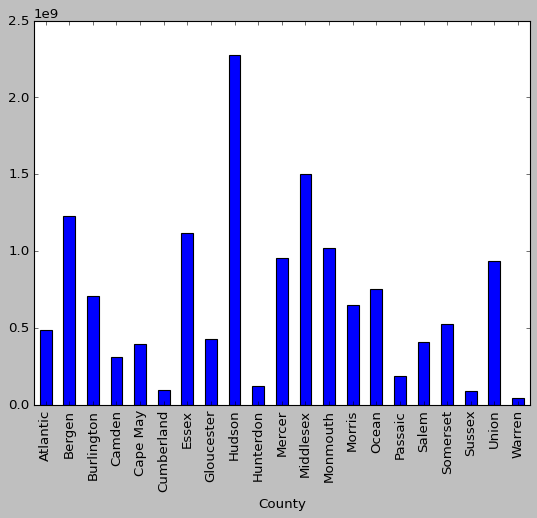

In [38]:
ax=grouped['value'].plot(kind="bar")

##2nd Merge
To set up my second merge, I recreated the first merge just with a new name to help keep track of dataframes, but this time specifying 'Municipality' and 'DCA' for the columns to merge on.

This merge allows me to group the data by 'Municipality' so that I can eventually create the bar graph below. This time, the bar graph displays the total number of awarded permits by County.



In [39]:
codespermits2 = municodes.merge(permits, how='outer', on=['Municipality', 'DCA'])
codespermits2.drop_duplicates()

County   DCA      value
Municipality                              
Absecon          Atlantic   101        NaN
Atlantic City    Atlantic   102  2100000.0
Atlantic City    Atlantic   102   337400.0
Atlantic City    Atlantic   102  2217000.0
Atlantic City    Atlantic   102   555200.0
...                   ...   ...        ...
Washington Boro       NaN  2121  1000000.0
Washington Twp        NaN  2122   426124.0
Washington Twp        NaN  2122   742000.0
Washington Twp        NaN  2122   276000.0
Washington Twp        NaN  2122   515000.0

[9381 rows x 3 columns]

In [40]:
new = codespermits2.groupby("Municipality").count()
new = new.rename(columns={'County': 'CountyObvs'})

In [41]:
new2 = pd.merge(new, municodes, how='inner', left_on=["Municipality"], right_on=["Municipality"])
new2.drop_duplicates()

CountyObvs  DCA_x  value      County  DCA_y
Municipality                                                    
Aberdeen Township             1      1      0    Monmouth   1301
Absecon                       1      1      0    Atlantic    101
Alexandria Township           1      1      0   Hunterdon   1001
Allamuchy Township            1      1      0      Warren   2101
Allendale Borough             1      1      0      Bergen    201
...                         ...    ...    ...         ...    ...
Woodlynne Borough             1      1      0      Camden    437
Woodstown Borough             1      1      0       Salem   1715
Woolwich Township             1      1      0  Gloucester    824
Wrightstown Borough           1      1      0  Burlington    340
Wyckoff Township              1      1      0      Bergen    270

[564 rows x 5 columns]

In [42]:
grouped2 = new2.groupby('County').agg({'CountyObvs': 'sum'})
print (grouped2)

            CountyObvs
County                
Atlantic           260
Bergen             100
Burlington          46
Camden              39
Cape May           190
Cumberland          19
Essex               23
Gloucester          34
Hudson             409
Hunterdon           30
Mercer              15
Middlesex           26
Monmouth            54
Morris              43
Ocean               34
Passaic             16
Salem               15
Somerset            24
Sussex              24
Union               23
Warren              32


In [43]:
grouped2 = grouped2.sort_values(['County', 'CountyObvs'], ascending=[True, True])
grouped2

CountyObvs
County                
Atlantic           260
Bergen             100
Burlington          46
Camden              39
Cape May           190
Cumberland          19
Essex               23
Gloucester          34
Hudson             409
Hunterdon           30
Mercer              15
Middlesex           26
Monmouth            54
Morris              43
Ocean               34
Passaic             16
Salem               15
Somerset            24
Sussex              24
Union               23
Warren              32

##2nd Bar Graph
This bar graph allows me to observe the total number of awarded permits by County, which differs from the above graph which displayed total dollars of permits by County. This graph is a better visualization for answering my research questions and hypotheses since the behavior of planning boards is better understood through frequency of permits rather than value of permits.

In this view, Hudson and Atlantic Counties are definite outliers compared to other counties. Unfortunately, though, this view also does not work toward my hypothesis regarding the influence of the County Line system, and the lack of such system in Salem and Sussex counties.

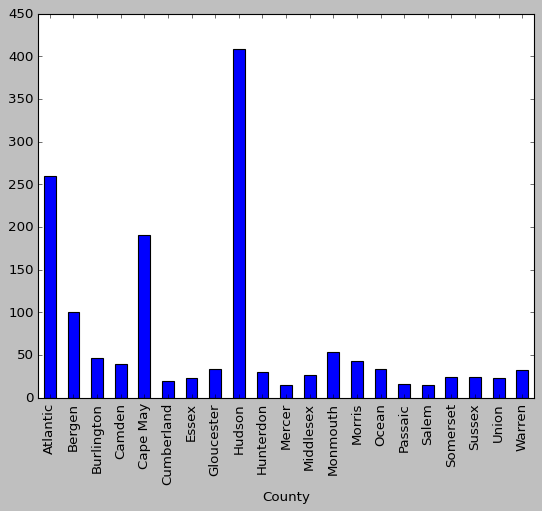

In [44]:
ax=grouped2['CountyObvs'].plot(kind="bar")

##3rd Merge
This merge combines the new2 dataset with the taxes dataset. Often, planning board members approve of permits in the spirit of increasing rateables for a municipality, essentially implying that such an approval could be good for lowering residents' property taxes. Therefore, it is important to bring in data related to property tax.

Here, the MedianTax Column represents the median property tax amount for each municipality in New Jersey.

In [45]:
taxstart = pd.merge(new2, taxes, how='inner', left_on=["Municipality", "County"], right_on=["Municipality", "County"])
taxstart.drop_duplicates()

CountyObvs  DCA_x  value     County  DCA_y  MedianTax
Municipality                                                                 
Aberdeen Township                1      1      0   Monmouth   1301     7018.0
Aberdeen Township                1      1      0   Monmouth   1301     7851.0
Aberdeen Township                1      1      0   Monmouth   1301     9866.0
Aberdeen Township                1      1      0   Monmouth   1301    10000.0
Allamuchy Township               1      1      0     Warren   2101     9084.0
...                            ...    ...    ...        ...    ...        ...
Woodbridge Township              1      1      0  Middlesex   1225     9328.0
Woodcliff Lake Borough           1      1      0     Bergen    268    10000.0
Woodland Park Borough            1      1      0    Passaic   1616     9905.0
Woodland Park Borough            1      1      0    Passaic   1616    10000.0
Wyckoff Township                 1      1      0     Bergen    270    10000.0

[846 rows x 6 columns]

##Another groupby / agg
Since the above analyses focus on counties, the below commands work toward creating the 'together' dataset, which is made up of 'County' and 'MedianTax' variables.

In [46]:
together = taxstart.groupby('County').agg({'MedianTax': 'mean'})
print (together)

              MedianTax
County                 
Bergen      9550.171429
Burlington  6859.857143
Essex       9622.252427
Hudson      8198.336364
Hunterdon   9459.000000
Mercer      8476.728814
Middlesex   8546.246914
Monmouth    8654.507576
Morris      9340.683673
Ocean       7419.228070
Passaic     9517.568182
Somerset    8889.643836
Sussex      7655.621622
Union       9641.038462
Warren      7810.923077


In [47]:
together = together.sort_values(['County', 'MedianTax'], ascending=[True, True])
together

MedianTax
County                 
Bergen      9550.171429
Burlington  6859.857143
Essex       9622.252427
Hudson      8198.336364
Hunterdon   9459.000000
Mercer      8476.728814
Middlesex   8546.246914
Monmouth    8654.507576
Morris      9340.683673
Ocean       7419.228070
Passaic     9517.568182
Somerset    8889.643836
Sussex      7655.621622
Union       9641.038462
Warren      7810.923077

##MedianTax Bar Graph
Below, the bar graph displays the median property tax amount by county. Although some counties do have very high median property tax amounts, there does not seem to be much variation or any obvious outliers.

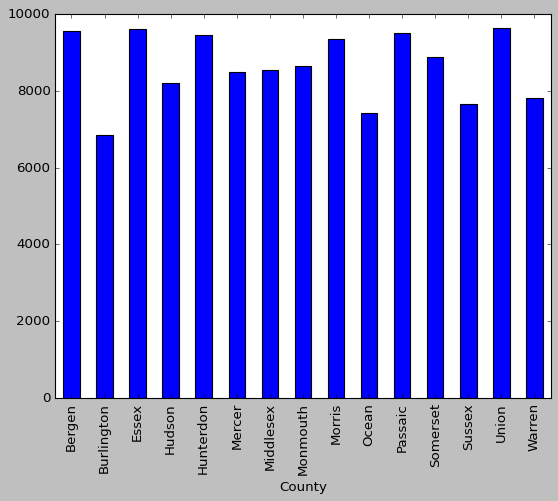

In [48]:
ax=together['MedianTax'].plot(kind="bar")

##Scatterplot #1
Since each county is made up of different municipalities, all of which may have different amounts of municipalities, I made the below scatterplot which displays MedianTax by County. This is helpful to observe the range of Median Property Tax of municipalities within the same county.

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='County', ylabel='MedianTax'>

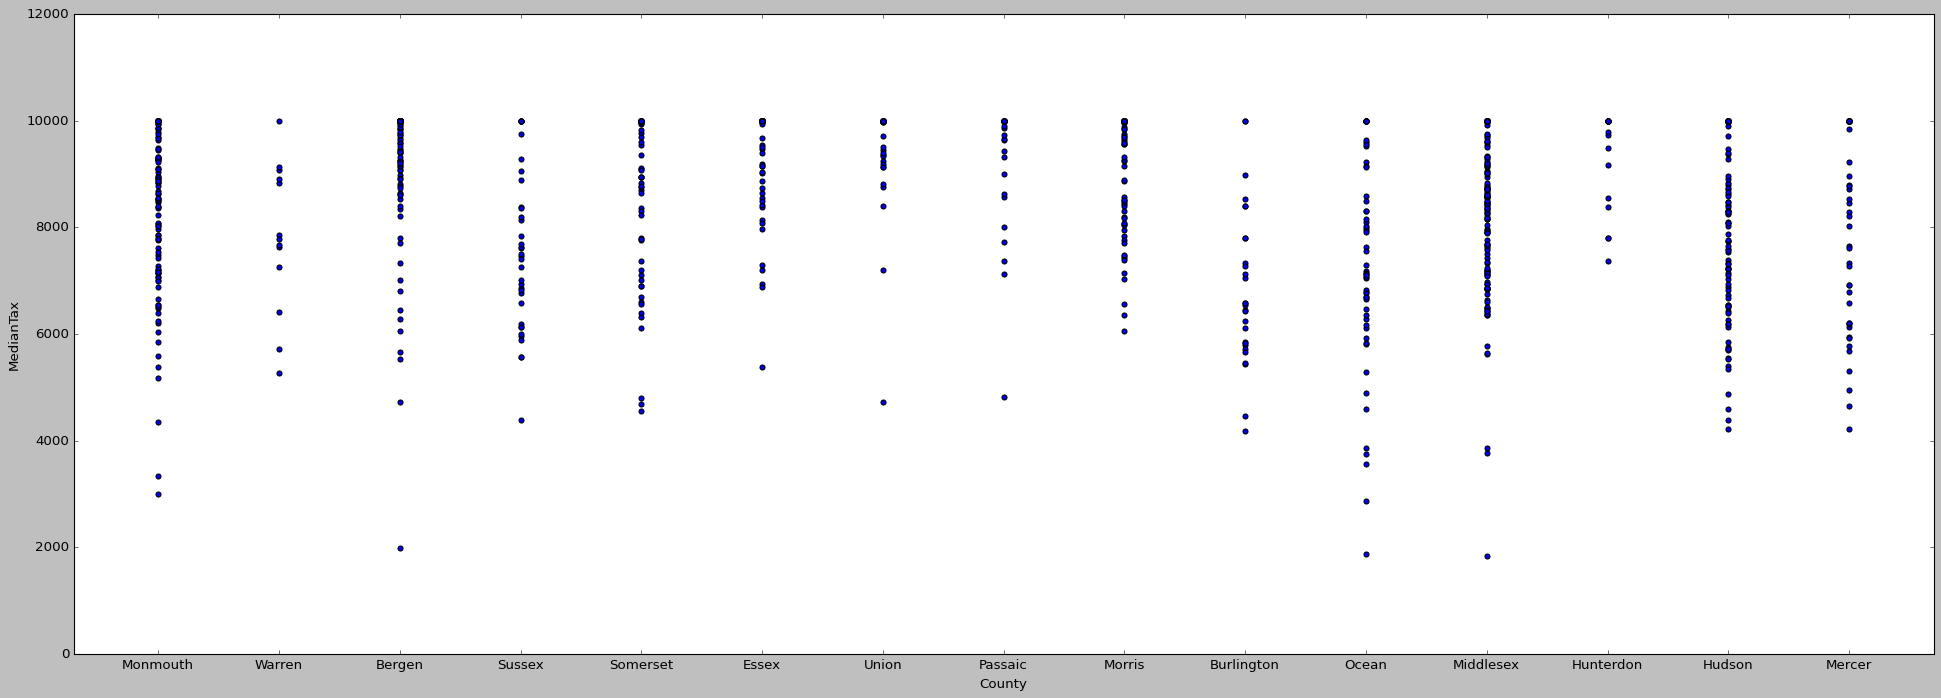

In [49]:
taxstart.plot.scatter(x='County', y='MedianTax', rot=0, figsize=(30, 10))

In [50]:
taxstart2 = pd.merge(new2, taxes, how='outer', left_on=["Municipality", "County"], right_on=["Municipality", "County"])
taxstart2.drop_duplicates()

CountyObvs  DCA_x  value     County   DCA_y  \
Municipality                                                                    
Aberdeen Township                        1.0    1.0    0.0   Monmouth  1301.0   
Aberdeen Township                        1.0    1.0    0.0   Monmouth  1301.0   
Aberdeen Township                        1.0    1.0    0.0   Monmouth  1301.0   
Aberdeen Township                        1.0    1.0    0.0   Monmouth  1301.0   
Absecon                                  1.0    1.0    0.0   Atlantic   101.0   
...                                      ...    ...    ...        ...     ...   
Rahway City                              NaN    NaN    NaN      Union     NaN   
Rahway City                              NaN    NaN    NaN      Union     NaN   
Rahway City                              NaN    NaN    NaN      Union     NaN   
Rahway City                              NaN    NaN    NaN      Union     NaN   
Lebanon Township/Califon Borough         NaN    NaN    NaN  Hunterdon     NaN   

                                  MedianTax  
Municipality                                 
Aberdeen Township                    7018.0  
Aberdeen Township                    7851.0  
Aberdeen Township                    9866.0  
Aberdeen Township                   10000.0  
Absecon                                 NaN  
...                                     ...  
Rahway City                          8733.0  
Rahway City                          8220.0  
Rahway City                          7987.0  
Rahway City                          7421.0  
Lebanon Township/Califon Borough     9439.0  

[1452 rows x 6 columns]

##Final Merge
This merge brings in data on Job Density by Municipality. Since some planning board members make arguments that more development means more jobs, it is wise to take a look and see if that actually happens.

In [51]:
taxstart = taxstart.rename(columns={'DCA_y': 'DCA'})
final = pd.merge(taxstart2, jobs, how='outer', left_on=["Municipality", "County"], right_on=["Municipality", "County"])
final.drop_duplicates()

CountyObvs  DCA_x  value      County   DCA_y  MedianTax  \
Municipality                                                                 
Aberdeen Township         1.0    1.0    0.0    Monmouth  1301.0     7018.0   
Aberdeen Township         1.0    1.0    0.0    Monmouth  1301.0     7018.0   
Aberdeen Township         1.0    1.0    0.0    Monmouth  1301.0     7018.0   
Aberdeen Township         1.0    1.0    0.0    Monmouth  1301.0     7851.0   
Aberdeen Township         1.0    1.0    0.0    Monmouth  1301.0     7851.0   
...                       ...    ...    ...         ...     ...        ...   
Camden City               NaN    NaN    NaN      Camden     NaN        NaN   
Camden City               NaN    NaN    NaN      Camden     NaN        NaN   
Hammonton Town            NaN    NaN    NaN    Atlantic     NaN        NaN   
--                        NaN    NaN    NaN       Ocean     NaN        NaN   
Woodbury City             NaN    NaN    NaN  Gloucester     NaN        NaN   

                   JobsDensity  
Municipality                    
Aberdeen Township  1348.553352  
Aberdeen Township   338.238461  
Aberdeen Township   643.769570  
Aberdeen Township  1348.553352  
Aberdeen Township   338.238461  
...                        ...  
Camden City        2440.410004  
Camden City         384.355971  
Hammonton Town      116.216712  
--                    0.000000  
Woodbury City       994.178765  

[21889 rows x 7 columns]

##Job Density vs. Median Tax ScatterPlot
Generating these scatterplots side-by-side is interesting. Hudson County remains an outlier. Mercer County shows a more even distribution of property tax, but a less evenly distributed job desnity. What would be helpful in these scatterplots would be a way to arrange the counties by continuity, since some social affects may spill from one town to the other, but across county boundaries.

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='County', ylabel='JobsDensity'>

<Axes: xlabel='County', ylabel='MedianTax'>

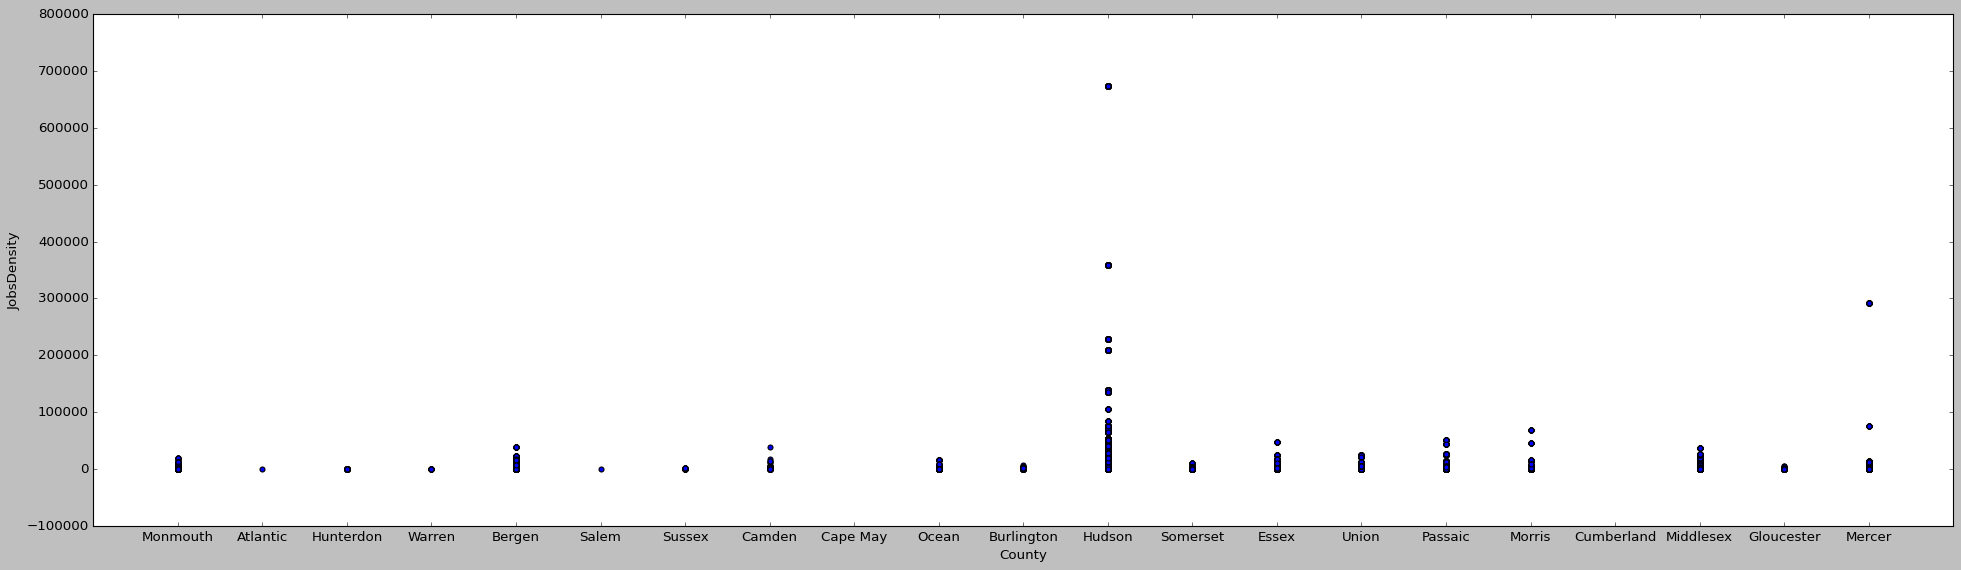

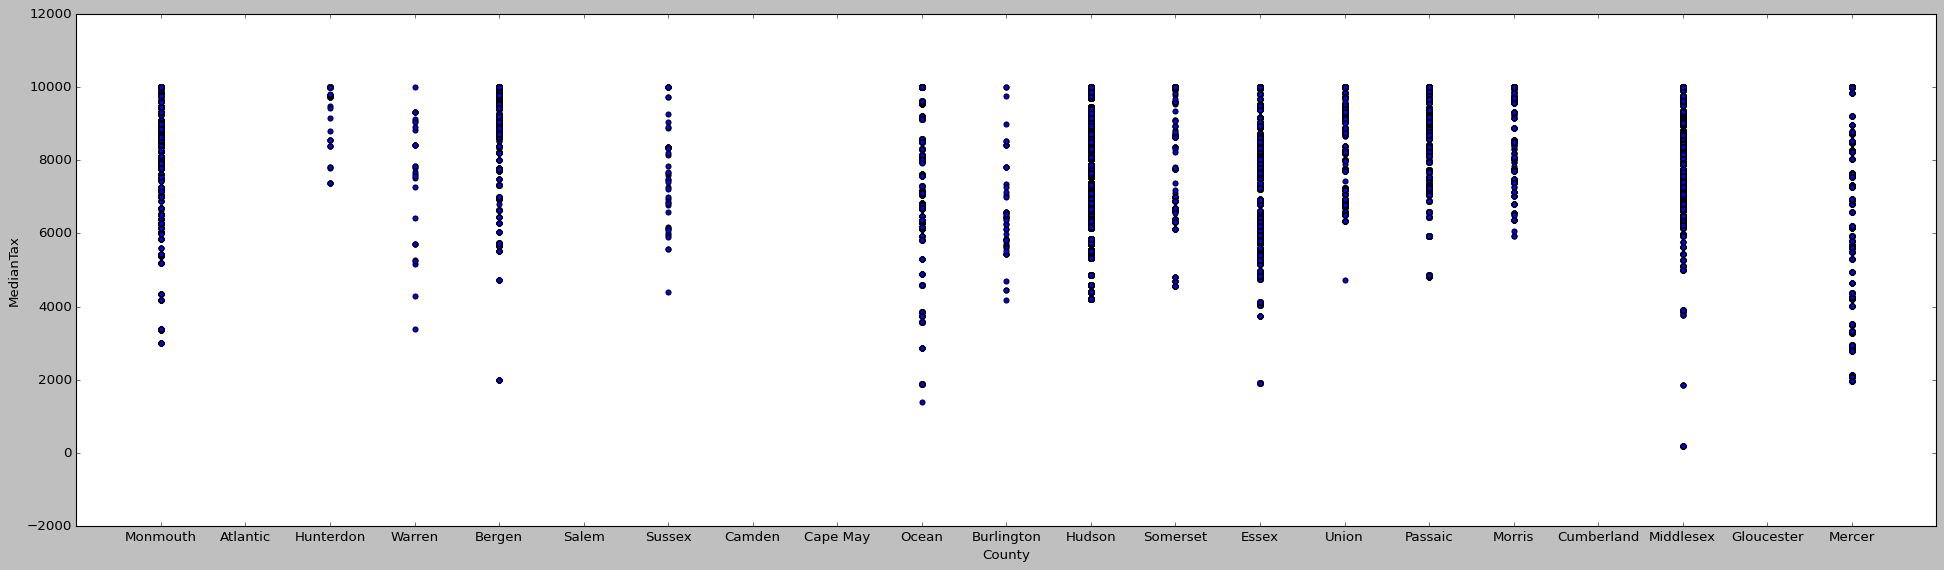

In [52]:
final.plot.scatter(x='County', y='JobsDensity', rot=0, figsize=(30, 8))
final.plot.scatter(x='County', y='MedianTax', rot=0, figsize=(30, 8))

##Conclusion
Based upon the above merges and graphs, it is clear that there is more work to be done. First, although the provided data does not work toward answering my research questions or hypotheses, there is more that I can do to understand the 'permits' dataset. For example, I should look into the Types of permits that were awarded, and see if there are any particular trends in specific municipalities. For example, I might ask, "Why is Municipality #20 approving so many New permits, while Municipality #22 is not?".

There is also the opportunity for me to use this notebook as a framework in exploring other datasets for my dissertation. This notebook does not include population data, but easily could. Total number of residents, and demographic information can feed into town-by-town analysis, which could lead back to an analysis of counties and the County Line system.

Finally, though, this notebook does offer justification for further exploring the specific instance of Hudson County. Why is that county approving so many more permits and such higher value versus other counties? Is it the county's proximity to New York City? Or, does this data work toward showing effects of the Hudson County Democratic Machine, and pay-to-play politics?